In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
#print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

We take one single galaxy bin and compute KK, NK, and NN using camb, and compare the results wiht those computed by hand. 

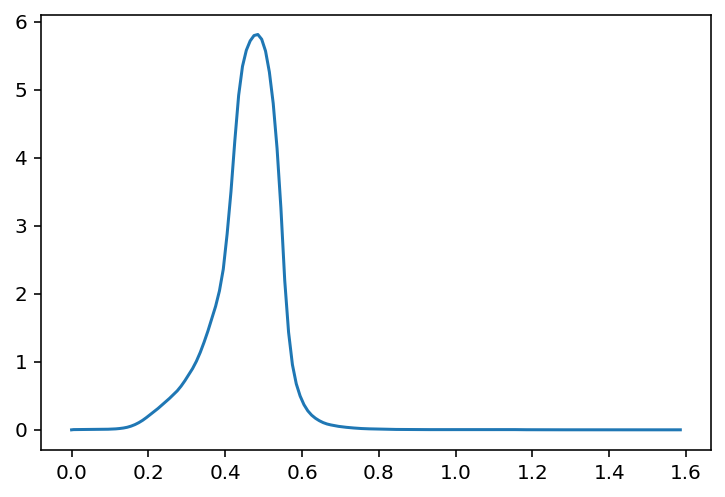

In [2]:
# load the source
z0 = np.loadtxt('nz/z.txt')
nz0 = np.loadtxt(f'nz/bin_{2}.txt')
bias = 1.666
plt.plot(z0,nz0)

In [3]:
# compute using camb
def get_nonlin():
    #Set up a new set of parameters for CAMB
    pars = camb.CAMBparams()
    #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
    pars.set_cosmology(H0=67.77, ombh2=0.0221399, omch2=0.1189110, mnu=0.0, omk=0, tau=0.06)
    pars.InitPower.set_params(As=2.0983651e-9, ns=0.96, r=0)
    pars.set_for_lmax(5000, lens_potential_accuracy=2);
    pars.SourceWindows = [SplinedSourceWindow(dlog10Ndm=0, z=z0, W=nz0, bias=bias)]
    pars.NonLinear = model.NonLinear_both
    results = camb.get_results(pars)
    cl_camb=results.get_cmb_unlensed_scalar_array_dict(raw_cl=False,CMB_unit='muK')
    return cl_camb
cl_camb = get_nonlin()

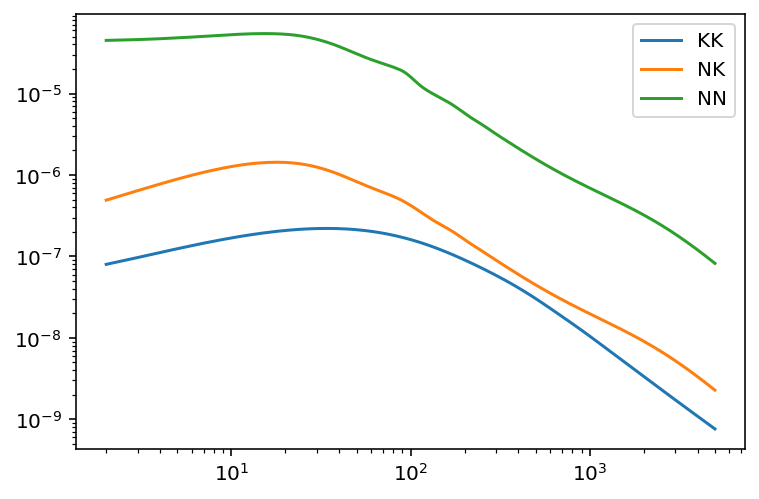

In [4]:
# Plot the KK, NK, and NN powerspectrum 
ell = np.arange(2,5001)
plt.loglog(ell,cl_camb['PxP'][2:5001]*np.pi/2,
           label='KK',color='tab:blue')
plt.loglog(ell,cl_camb['W1xP'][2:5001]*np.sqrt(2*np.pi/(ell*(ell+1)))*np.sqrt(np.pi/2),
           label='NK',color='tab:orange')
plt.loglog(ell,cl_camb['W1xW1'][2:5001]*2*np.pi/(ell*(ell+1)),
           label='NN',color='tab:green')
plt.legend()

Now we compute everything by manually integration

In [5]:
# setup camb
num = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
#First set up parameters as usual
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.77, ombh2=0.0221399, omch2=0.1189110, mnu=0.0, omk=0, tau=0.06)
pars.InitPower.set_params(As=2.0983651e-9, ns=0.96, r=0)
results= camb.get_results(pars)

### KK
The equation for KK is 
$$C_l^{\kappa\kappa}=[l(l+1)]^2\int_0^{\chi_*}d\chi\left(\frac{\chi_*-\chi}{\chi^2 \chi_*}\right)^2P_\Psi\left(\frac{l+0.5}{\chi},z(\chi)\right)$$

In [6]:
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,num)
zs=results.redshift_at_comoving_radial_distance(chis)

#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
dzs = (zs[2:]-zs[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]
azs = 1/(1+zs)

#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.

PK = camb.get_matter_power_interpolator(pars, nonlinear=True,
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1]) # for CMB lensing
PG = camb.get_matter_power_interpolator(pars, nonlinear=True,
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_tot, zmax=zs[-1]) # for galaxy lensing

In [7]:
#Do integral over chi
ls = np.arange(2,5000+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*((chistar-chis)/(chis**2*chistar))**2/k**4) # why do we need to divide by k^4?
#cl_kappa*= (ls*(ls+1))**2

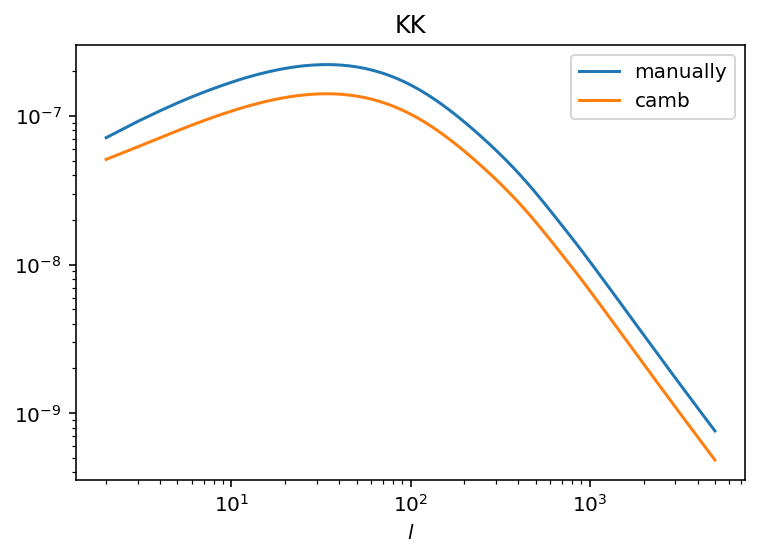

In [8]:
plt.loglog(ls,cl_kappa*(ls*(ls+1))**2,label='manually')
plt.loglog(ls,cl_camb['PxP'][2:5001],label='camb')
plt.title('KK')
plt.xlabel(r'$l$')
plt.legend()

### NK
The NK formula is
$$C^{\rm{NK}}_l=\frac{3\Omega_mH_0^2}{2c^2}\int\frac{d\chi}{\chi^2}\left(\frac{\chi}{a(\chi)}\frac{\chi^*-\chi}{\chi^*}\right)\left(b_g(\chi)n_g(z(\chi))\frac{dz}{d\chi}\right)P_{\rm NL}\left(\frac{l+0.5}{\chi},z(\chi)\right)$$

In [9]:
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,4500,num) # we will make finer chis with smaller upper bound, since n(z) is zero for large chis
zs=results.redshift_at_comoving_radial_distance(chis)

#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2 # d\chi
dzs = (zs[2:]-zs[:-2])/2 # dz
chis = chis[1:-1]
zs = zs[1:-1]
azs = 1/(1+zs) # scale factor is just 1/(1+z)

Text(0.5, 1.0, '$n(z(\\chi))$')

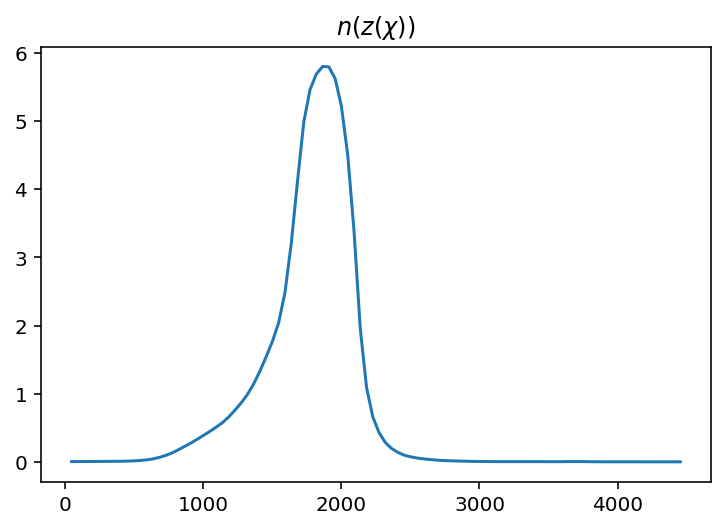

In [10]:
# spline the n(z)
spline = scipy.interpolate.InterpolatedUnivariateSpline(z0, nz0)
mask = (zs<=np.max(z0))
nz = np.concatenate((spline(zs[mask]),np.zeros_like(zs[np.invert(mask)])))
bias = 1.666
plt.plot(chis,nz)
plt.title(r'$n(z(\chi))$')

In [11]:
qg = bias*nz*dzs/dchis
qk = 1/chis*(chistar-chis)/chistar

In [12]:
cl_nk=np.zeros(ls.shape)
w = np.ones(chis.shape)
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_nk[i] = np.dot(dchis, w*qg*qk/chis**2*PK.P(zs, k, grid=False)/k**4)

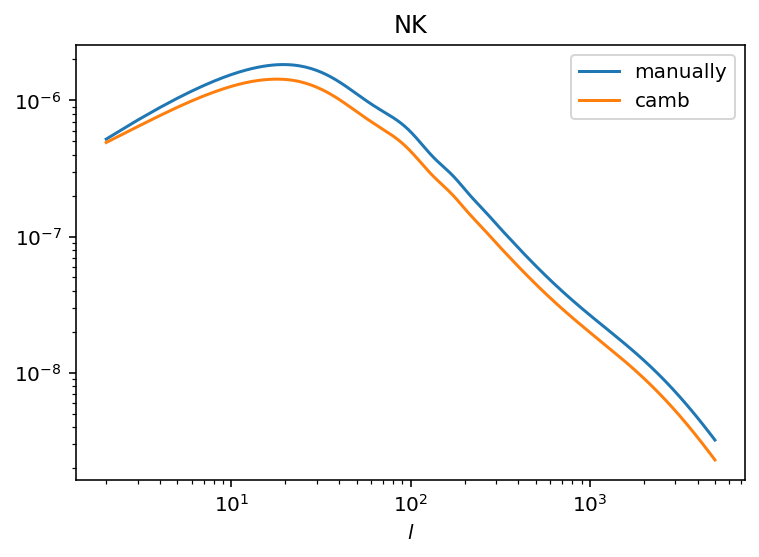

In [13]:
plt.loglog(ls,cl_nk*(ls*(ls+1))**2*1.2e1,
           label='manually') # 1.2e1 is to make bring both closer to each other, but (ls*(ls+1))**2 is just the normal normalization factor
plt.loglog(ls,cl_camb['W1xP'][2:5001]*np.sqrt(2*np.pi/(ell*(ell+1)))*np.sqrt(np.pi/2),
           label='camb')
plt.title('NK')
plt.xlabel(r'$l$')
plt.legend()

### NN
The NN formula is
$$C^{\rm{NN}}_l=\int\frac{d\chi}{\chi^2}\left(b^i_g(\chi)n^i_g(z(\chi))\frac{dz}{d\chi}\right)\left(b^j_g(\chi)n^j_g(z(\chi))\frac{dz}{d\chi}\right)P_{\rm NL}\left(\frac{l+0.5}{\chi},z(\chi)\right)$$

In [14]:
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,4500,num) # we will make finer chis with smaller upper bound, since n(z) is zero for large chis
zs=results.redshift_at_comoving_radial_distance(chis)

#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2 # d\chi
dzs = (zs[2:]-zs[:-2])/2 # dz
chis = chis[1:-1]
zs = zs[1:-1]
azs = 1/(1+zs) # scale factor is just 1/(1+z)

Text(0.5, 1.0, '$n(z(\\chi))$')

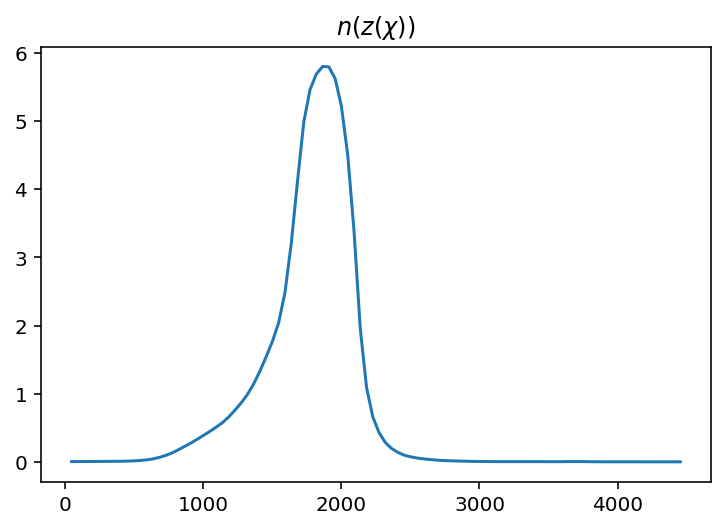

In [15]:
# spline the n(z)
spline = scipy.interpolate.InterpolatedUnivariateSpline(z0, nz0)
mask = (zs<=np.max(z0))
nz = np.concatenate((spline(zs[mask]),np.zeros_like(zs[np.invert(mask)])))
bias = 1.666
plt.plot(chis,nz)
plt.title(r'$n(z(\chi))$')

In [16]:
qg = bias*nz*dzs/dchis

In [17]:
cl_nn=np.zeros(ls.shape)
w = np.ones(chis.shape)
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_nn[i] = np.dot(dchis, w*qg*qg/chis**2*PK.P(zs, k, grid=False)/k**4)

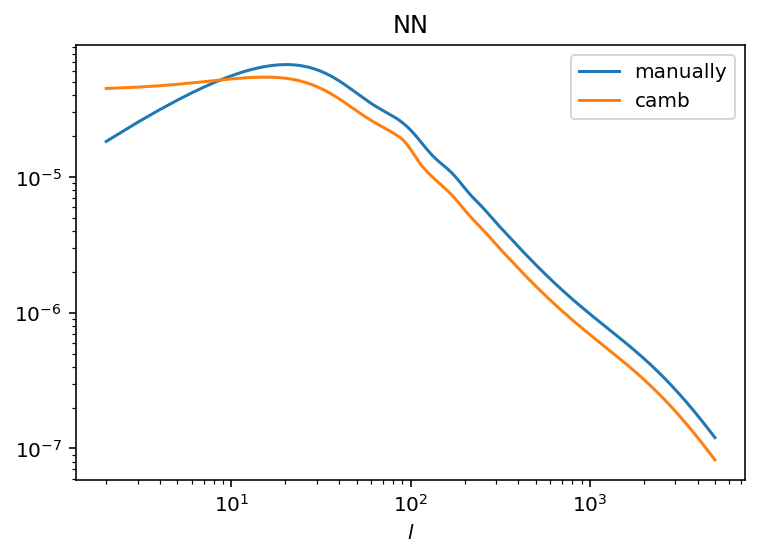

In [18]:
plt.loglog(ls,cl_nn*(ls*(ls+1))**2*1e2,
           label='manually') # 1e2 is to make bring both closer to each other, but (ls*(ls+1))**2 is just the normal normalization factor
plt.loglog(ls,cl_camb['W1xW1'][2:5001]*2*np.pi/(ell*(ell+1)),
           label='camb')
plt.title('NN')
plt.xlabel(r'$l$')
plt.legend()

Note that we used `var2=model.Transfer_Weyl` in the above. if we use `Transfer_tot` then we would get negative values

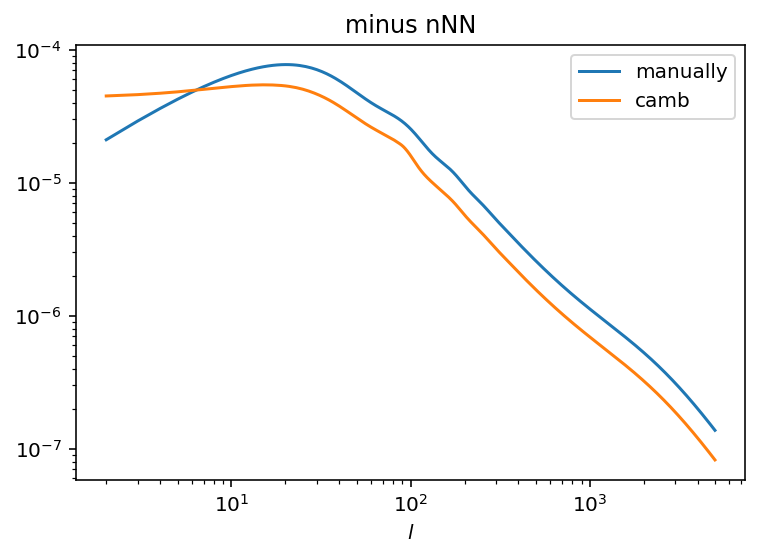

In [19]:
cl_nn=np.zeros(ls.shape)
w = np.ones(chis.shape)
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_nn[i] = np.dot(dchis, w*qg*qg/chis**2*PG.P(zs, k, grid=False)/k**4)

plt.loglog(ls,-cl_nn*(ls*(ls+1))**2*4e-6,
           label='manually') # 4e-6 is to make bring both closer to each other, but (ls*(ls+1))**2 is just the normal normalization factor
plt.loglog(ls,cl_camb['W1xW1'][2:5001]*2*np.pi/(ell*(ell+1)),
           label='camb')
plt.title('minus nNN')
plt.xlabel(r'$l$')
plt.legend()